# Rosenbrocks system Analysis

All needed information for controller design of Rosenbrocks system

In [1]:
# Import the needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as cn
import paperfunction as pf
#import modelicares as mres

## System evaluation

Compute the poles and zeros of the tranfer function.

First, get the approximation of the system which is decoupled via the simple static decoupler.

$g^*_{11} = \frac{1-s}{(s+1)(s+3)} $

In [2]:
T, L = pf.MODEL_TO_FOTD([-1.],[1.,1./3.])
T,L

(1.1666666666666667, 1.1666666666666667)

So, the model is given by:

$g^*_{11} = \frac{1}{3} \frac{1}{1.16666...s+1}e^{-1.166666s}$

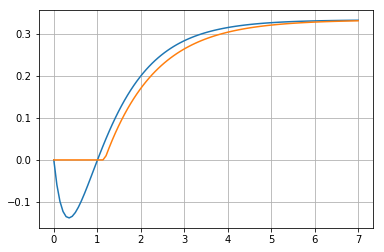

In [3]:
# Get the real system
g = cn.tf([-1.,1.],[1.,1.])*cn.tf([1./3.],[1./3.,1])
y, t = cn.step(g)
# Get the approximate model response
yM = pf.Simulate_FOPTD(1./3., float(T), float(L), t)
# Make a plot
plt.clf()
plt.plot(t,y, label = "Real System")
plt.plot(t,yM, label = "Model System")
plt.grid(True)
plt.show()

Since for a simple dynamic decoupler the transfer functions stays the same, the approximation holds further.

The AMIGO parameter can be calculated to:

In [4]:
# First controller
c11,b11 = pf.AMIGO_TUNE(1./3.,T,L)
# Second controller, simple static decoupler g_22
c22, b22 = pf.AMIGO_TUNE(1./3.,1.,0.)

c11, c22

([0.75, 0.6428571428571429, 0.0],
 [2.1748520710059176, 2.5565504267918477, 0.0])

So the resulting controller for a simple static decoupler is given by:

$c_{S,11} = 0.75 + \frac{0.642...}{s}$ 

$c_{S,22} = 2.1748... + \frac{2.5565...}{s}$

And for a simple dynamic decoupler:

$c_{D,11} = 0.75 + \frac{0.642...}{s}$ 

$c_{D,22} = 0.75 + \frac{0.642...}{s}$

Now, the generalized multivariable controller is calculated. Since the process is hard to automate, look into the draft of the paper.

## Simulation

Simulate the dymola systems via the interface.

In [5]:
# General Information
# Model to simulate, here the folder and the modelica file containing the model needs to be specified.
Model_Path = "../Modelica/Rosenbrock_Gain.mo"
# Simulation Parameter, here the simulation parameter have to be specified.
sim_parameter = {
    "Model" : "Rosenbrock_Gain.Ideal",
    "stopTime" : 1200,
    "Intervals": 1e2,
    "OutputInterval" : 0.1,
    "Stepsize" : 0.1,
    "Result" : "../Data/Rosenbrock/Ideal",
    "finalNames" : ["y_1","y_2","u_1","u_2", "IAE_1.y", "IAE_2.y", "IE_1", "IE_2"],
}
# Initialize the model
model = pf.Initialize_Simulation(Model_Path)

### Ideal System

Ideal diagonal system

In [6]:
# Run the simulation
pf.Run_Simulation(model, sim_parameter)

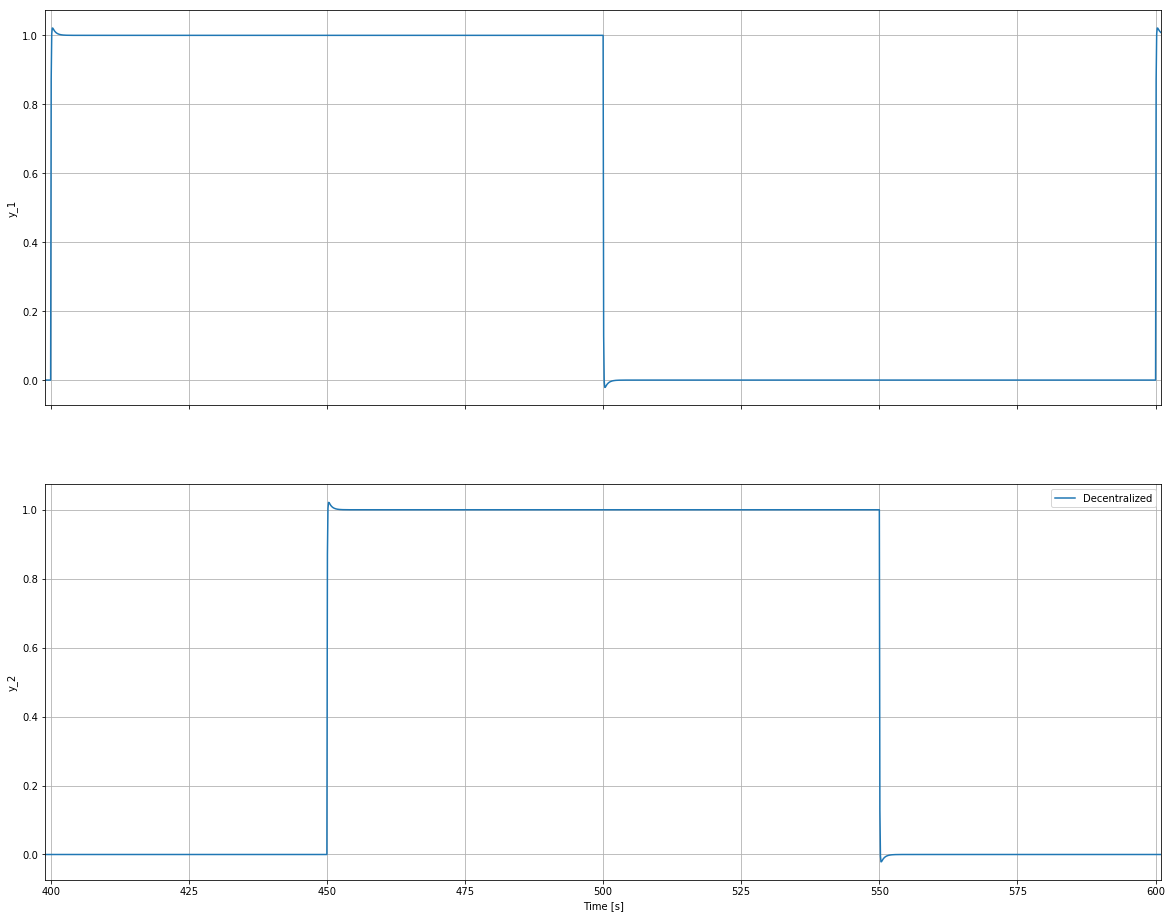

In [7]:
# Get the simulation data
Data = pf.Simulation_Results("../Data/Rosenbrock/Ideal.mat")

# Plot the Data
plt.clf()
fig, ax = plt.subplots(2, sharex = True, figsize = (20,16))

ax[0].plot(Data["time"], Data["y1"], label = "Ideal System")

ax[1].plot(Data["time"], Data["y2"], label = "Decentralized")

ax[1].legend()
ax[0].set_ylabel('y_1')
ax[0].grid(True)
ax[1].set_ylabel('y_2')
ax[1].set_xlabel('Time [s]')
ax[1].grid(True)
ax[0].set_xlim([399,601])
plt.show()


### Gain Study for Decentralized system

Decentralized controlled system;

Steps to be taken:
- Get the system behaviour without additional gain
- Amplify every gain K_11 / K_22 individually until the closed loop collapses
- Amplify both gains until the closed loop collapses

In [8]:
# Update the simulation model, the model to be simulated is Decentralized, the Results need to be written into this file.
sim_parameter.update({"Model" : "Rosenbrock_Gain.Decentralized", "Result": "../Data/Rosenbrock/Decentralized"})
# To be safe, set the gains to 1
sim_parameter.update({"initialNames":["K_11.k", "K_22.k"], "initialValues":[1.0,1.0]})
# Simulation of the original system without additional input gain
pf.Run_Simulation(model, sim_parameter)

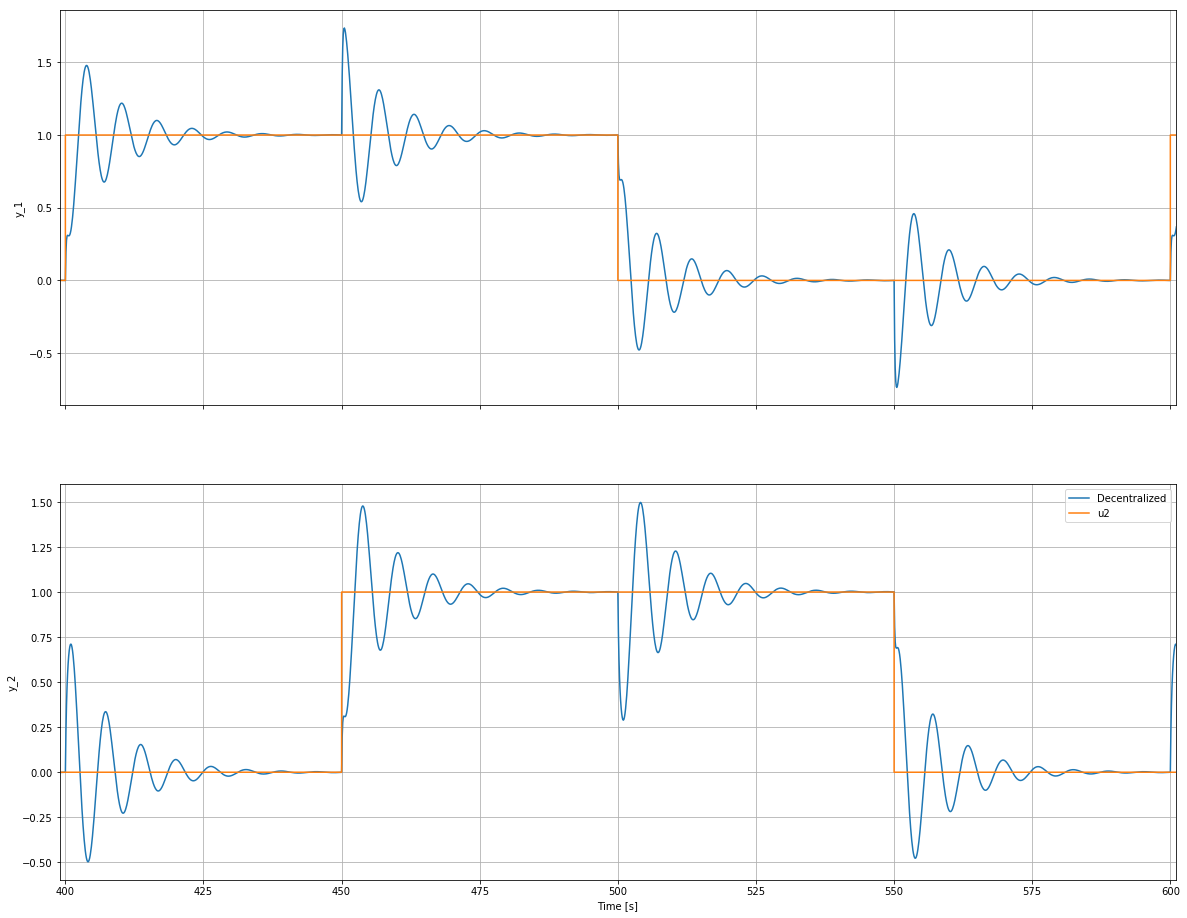

In [9]:
# Open the data
Data = pf.Simulation_Results(sim_parameter["Result"]+".mat")
# Plot the Data
plt.clf()
fig, ax = plt.subplots(2, sharex = True, figsize = (20,16))

ax[0].plot(Data["time"], Data["y1"], label = "Decentralized")
ax[0].plot(Data["time"], Data["u1"])

ax[1].plot(Data["time"], Data["y2"], label = "Decentralized")
ax[1].plot(Data["time"], Data["u2"])

ax[1].legend()
ax[0].set_ylabel('y_1')
ax[0].grid(True)
ax[1].set_ylabel('y_2')
ax[1].set_xlabel('Time [s]')
ax[1].grid(True)
ax[0].set_xlim([399,601])
plt.show()

In [10]:
# Check the stability via the systems output and the set point u1 and u2
pf.Stability(Data["y1"],Data["u1"]) and pf.Stability(Data["y2"], Data["u2"])

ValueError: Can only tuple-index with a MultiIndex

In [ ]:
# Increase the gain to simulate non stable behavior
sim_parameter.update({"initialValues" : [2., 2.]})

# Simulation of the original system without additional input gain
pf.Run_Simulation(model, sim_parameter)

# Open the data
Data = pf.Simulation_Results(sim_parameter["Result"]+".mat")
# Plot the Data
plt.clf()
fig, ax = plt.subplots(2, sharex = True, figsize = (20,16))

ax[0].plot(Data["time"], Data["y1"], label = "Decentralized")
ax[0].plot(Data["time"], Data["u1"])

ax[1].plot(Data["time"], Data["y2"], label = "Decentralized")
ax[1].plot(Data["time"], Data["u2"])

ax[1].legend()
ax[0].set_ylabel('y_1')
ax[0].grid(True)
ax[1].set_ylabel('y_2')
ax[1].set_xlabel('Time [s]')
ax[1].grid(True)
ax[0].set_xlim([399,601])
plt.show()

# Check the stability via the systems output and the set point u1 and u2
pf.Stability(Data["y1"],Data["u1"]) and pf.Stability(Data["y2"],Data["u2"])

In [ ]:
sim_parameter